### Analisis exploratorio de KPIs por nico

#### Objetivos

1 - predecir el consumo de energia para 2030 \
2 - predecir la demanda de energia para 2030 de energias renovables

In [66]:
import pandas as pd
import plotly.express as px
import typing as T
from plotly.graph_objects import Figure

In [552]:
data = pd.read_parquet('../datasets/energy_consumption/owid-energy-consumption-source_normalizado.parquet')
data.head()

,pais,anio,pais_iso,poblacion,pbi,biocombustible_cons,biocombustible_elec,biocombustible_share_energia,carbon_intensidad_elec,carbon_cons,...,other_renovable_elec,other_renewable_exc_biocombustible_elec,primary_energia_cons,renovables_cons,renovables_elec,solar_cons,solar_elec,eolica_cons,eolica_elec,eolica_share_energia
0,Afghanistan,1980,AFG,13356500.0,1.532984e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1981,AFG,13171679.0,1.564534e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1982,AFG,12882518.0,1.598041e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1983,AFG,12537732.0,1.675533e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1984,AFG,12204306.0,1.707215e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.columns

Index(['pais', 'anio', 'pais_iso', 'poblacion', 'pbi', 'biocombustible_cons',
       'biocombustible_elec', 'biocombustible_share_energia',
       'carbon_intensidad_elec', 'carbon_cons', 'carbon_elec',
       'carbon_produccion', 'elec_demand', 'elec_generation',
       'energia_per_pbi', 'fossil_elec', 'fossil_combustible_cons', 'gas_cons',
       'gas_elec', 'gas_produccion', 'greenhouse_gas_emision_co2s',
       'hydro_cons', 'hydro_elec', 'low_carbon_cons', 'low_carbon_elec',
       'net_elec_imports', 'nuclear_cons', 'nuclear_elec', 'petroleo_cons',
       'petroleo_elec', 'petroleo_produccion', 'other_renovable_cons',
       'other_renovable_elec', 'other_renewable_exc_biocombustible_elec',
       'primary_energia_cons', 'renovables_cons', 'renovables_elec',
       'solar_cons', 'solar_elec', 'eolica_cons', 'eolica_elec',
       'eolica_share_energia'],
      dtype='object')

### Sacar top carbon, oil, gas
consumo
elec
production

In [572]:
# Data consumo

class BadEnergies(pd.DataFrame): 
    meta = '' 
    
    def __init__(self, *args, **kwargs):
        return super(BadEnergies, self).__init__(*args, **kwargs)
    
    @property
    def _constructor(self):
        return BadEnergies
    
    def _get_top(self, n):
        data = self.copy()
        return list(
            data[[i for i in data.columns if i != 'anio']]
            .groupby('pais_iso')
            .mean()
            .sum(axis=1)
            .sort_values(ascending=False)
            .index[:n]
            .values
        )
    
    def _get_melt(self):
        return self.melt(
            id_vars=['pais_iso', 'anio'], 
            value_vars=filter(lambda x: x not in ['pais_iso', 'anio'], self.columns),
            value_name='valor', 
            var_name='tipo_energia'
        )
        
    def get_data(self, filt: T.Literal['cons', 'produccion']):
        BadEnergies.meta = filt
        bad_energies = [
            c 
            for c in self.columns 
            if (
                (
                   'gas' in c
                    or 'petroleo' in c
                    or 'carbon' in c
                    and not 'green' in c
                    and not 'low' in c
                )
            )
        ]
        data = self.copy()
        columns = [i for i in bad_energies if filt in i] + ['pais_iso', 'anio']
        data = data[columns]
        # data.head(5)
        return data
    
    def plot_and_top(self, column, show=False):
        data = self.copy()
        col = column + '_' + self.meta
        fig = px.bar(top_carbon := (
            data[['pais_iso', col]]
            .groupby('pais_iso')
            .mean()
            .sort_values(col, ascending=False)
            .head(10)
        ))
        top_carbon_iso = top_carbon.index
        return fig, top_carbon_iso
    
    def fig_and_table(self):
        top = self._get_top(10)
        data = (
            self.copy()
            ._get_melt()
            .drop('anio', axis=1)
            .groupby(['pais_iso', 'tipo_energia'])
            .mean()
            .loc[top]
            .reset_index()
        )
        return px.bar(
            data,
            x='pais_iso',
            y='valor',
            color='tipo_energia'
        
        ), data

In [573]:
# Data consumo
data_cons = BadEnergies(data).get_data('cons')
data_cons.head()

,carbon_cons,gas_cons,petroleo_cons,pais_iso,anio
0,NaN,NaN,NaN,AFG,1980
1,NaN,NaN,NaN,AFG,1981
2,NaN,NaN,NaN,AFG,1982
3,NaN,NaN,NaN,AFG,1983
4,NaN,NaN,NaN,AFG,1984


In [574]:
# Graficas arbitrarias para cada tipo de energia

# Carbon
carbon_cons_fig, carbon_top_iso = data_cons.plot_and_top('carbon')

# Gas
gas_cons_fig, gas_top_iso = data_cons.plot_and_top('gas')

# Petroleo
petroleo_cons_fig, petroleo_top_iso = data_cons.plot_and_top('petroleo')

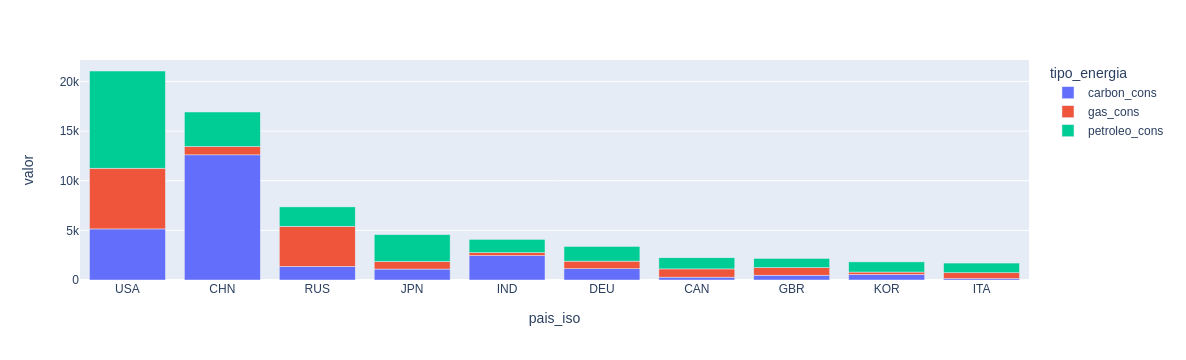

In [575]:
fig, cons_table = data_cons.fig_and_table()
fig.show()

In [576]:
cons_table.head()

,pais_iso,tipo_energia,valor
0,USA,carbon_cons,5145.399762
1,USA,gas_cons,6118.629762
2,USA,petroleo_cons,9791.675714
3,CHN,carbon_cons,12607.617619
4,CHN,gas_cons,839.669286


In [577]:
# Data produccion
data_produccion = BadEnergies(data).get_data('produccion')
data_produccion.head()

,carbon_produccion,gas_produccion,petroleo_produccion,pais_iso,anio
0,0.69,18.43,0.0,AFG,1980
1,0.73,24.26,0.0,AFG,1981
2,0.84,24.88,0.0,AFG,1982
3,0.84,26.10,0.0,AFG,1983
4,0.86,26.10,0.0,AFG,1984


In [581]:
# Graficas arbitrarias para cada tipo de energia

# Carbon
carbon_produccion_fig, carbon_top_iso = data_produccion.plot_and_top('carbon')

# gas
gas_produccion_fig, gas_top_iso = data_produccion.plot_and_top('gas')

# petroleo
petroleo_produccion_fig, petroleo_top_iso = data_produccion.plot_and_top('petroleo')

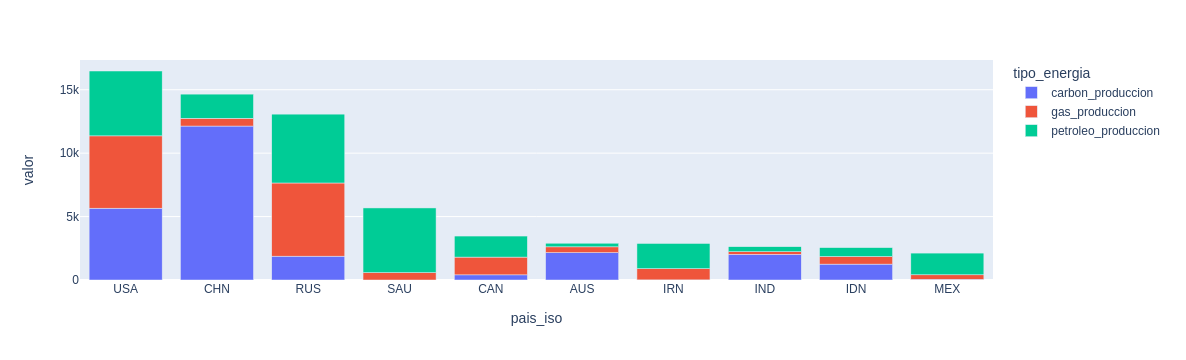

In [583]:
fig, cons_table = data_produccion.fig_and_table()
fig.show()

In [584]:
cons_table.head()

,pais_iso,tipo_energia,valor
0,USA,carbon_produccion,5660.379524
1,USA,gas_produccion,5701.898810
2,USA,petroleo_produccion,5113.708095
3,CHN,carbon_produccion,12136.642381
4,CHN,gas_produccion,612.115952


In [22]:
def plot_by_energy(energy: str, iso_code=None) -> Figure:
    
    if iso_code:
        bad_data: pd.DataFrame = data[bad_energies + ['anio', 'pais_iso']].loc[data['pais_iso'] == iso_code]
        color = None
    else:
        bad_data: pd.DataFrame = data[bad_energies + ['anio', 'pais_iso']]
        color = 'pais_iso'
        
    return px.line(
        bad_data,
        x='anio', 
        y=[i for i in bad_data.columns if energy in i],
        color=color
    )

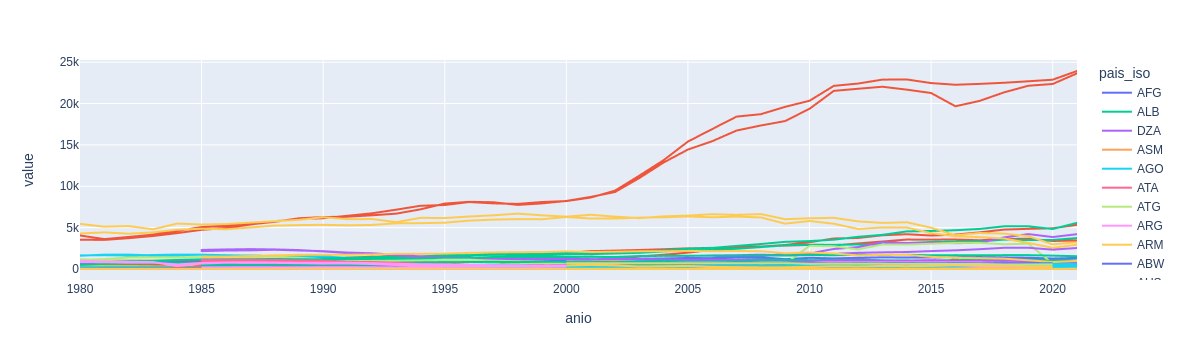

In [24]:
plot_by_energy('carbon')

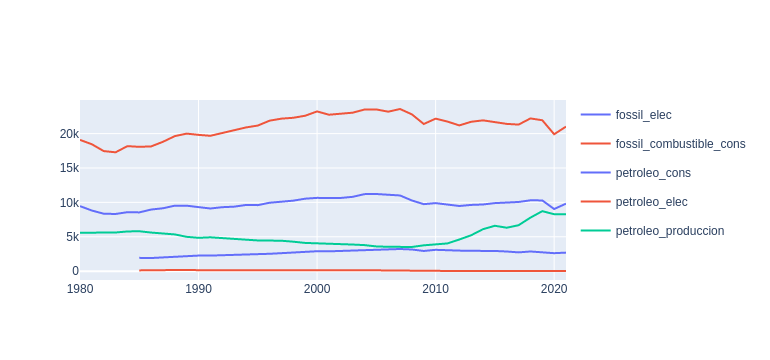

In [12]:
fossil_plot = plot_by_energy('fossil' ,'USA')
petroleo_plot = plot_by_energy('petroleo' ,'USA')
Figure(fossil_plot.data + petroleo_plot.data)

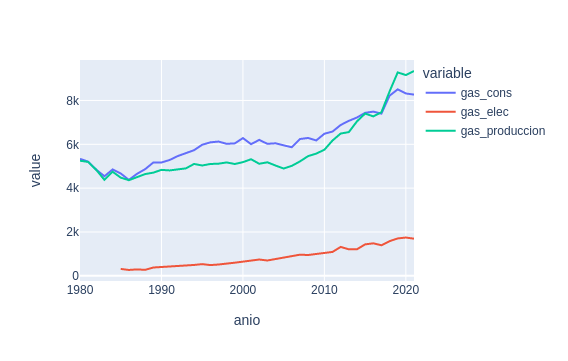

In [14]:
plot_by_energy('gas', 'USA')

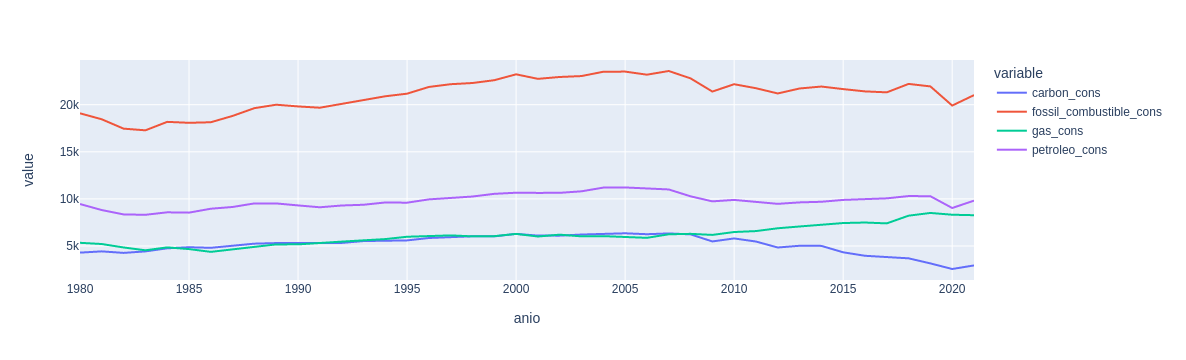

In [15]:
plot_by_energy('cons', 'USA')